<a href="https://colab.research.google.com/github/mlhbui/COMP-306/blob/main/M5_Lobbyist_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting to Socrata API

Retrieving the Lobbyist Contributions dataset from the Chicago Data Portal using the API endpoint. The function read_json receives the dataset and converts it into a usable dataframe. The "limit=7000" added to the end of the json file is to receive more rows than the default value of 1000. Reasons for getting all rows in the dataset (as opposed to a sample):
* Dataset is not significantly large so minimal loading time
* To view patterns across time a variety of data rows from different dates is needed

### M4: Connecting to Multiple Datasets

There is a helpful [image](https://www.chicago.gov/content/dam/city/depts/ethics/Images/Lobbyists-ERD-1.png) on the Chicago Data Portal on their connecting lobbyist datasets. From this page I used the following datasets:
* [Lobbyist, Employer, Client Combinations](https://data.cityofchicago.org/Ethics/Lobbyist-Data-Lobbyist-Employer-Client-Combination/2eqz-3nvz/about_data) which shows the central relationships between records
*[Lobbyist - Activity](https://data.cityofchicago.org/Ethics/Lobbyist-Data-Lobbying-Activity/pahz-egmi/about_data) which records the legislative actions lobbied.

These connections were established using similar methods to Milestone 3. These datasets were much larger, so transforming the dataframes involved more restrictions.

In [1]:
# resource installation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# M3
API_endpoint = 'https://data.cityofchicago.org/resource/p9p7-vfqc.json?$limit=7000'
master_df = pd.read_json(API_endpoint)

In [3]:
# M4: connecting to multiple dataframes

API_combo = 'https://data.cityofchicago.org/resource/2eqz-3nvz.json?$limit=27000'
m_combo_df = pd.read_json(API_combo)

API_activity = 'https://data.cityofchicago.org/resource/pahz-egmi.json?$limit=100000'
m_activity_df = pd.read_json(API_activity)

In [4]:
# M3 & 4 copying the master dataframes into working dfs

working_df = master_df.copy(deep='True')
w_activity_df = m_activity_df.copy(deep='True')
w_combo_df = m_combo_df.copy(deep='True')

# Transforming the Working Dataframe

In order to aid in analysis, visualizations, and improve the handling of the dataset the following actions were completed:
* removing outliers
* converting data to more usable formats
* removing unnecessary columns

In [5]:
# Method to convert dates to datetime format for visualizations
def parse_date(date_str):
    return pd.to_datetime(date_str, errors='coerce')

def column_count(df):
  for column in range(df.shape[1]):
    print(df[df.columns[column]].count())

### Identifying outliers

Columns for identification like lobbyist_id, recipient, and names can vary greatly since they are specific to the row. However, dates such as contribution_date or period_start may have outliers to deal with.

Using interquartile ranges, dates such as the ones found in contribution_date can be identified as outliers. The Lobbyist dataset only started recording contributions in the past decade, so dates in 2002 should be removed.

In [6]:
def find_outliers(column):
  # Calculate Q1 and Q3
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  # Calculate IQR
  IQR = Q3 - Q1
  # Define outlier range
  lower_bound = Q1 - 1.5 * IQR # Our call: 150% below IQR
  upper_bound = Q3 + 1.5 * IQR # also our call: 150% above IQR
  # Filter outliers based on IQR
  outliers_iqr = working_df[(column < lower_bound) | (column > upper_bound)]

  return(outliers_iqr)

In [7]:
# M3 Outliers

print("\nOutliers using IQR method:")
cd = working_df['contribution_date']
# must parse date before finding outliers
cd = pd.to_datetime(cd.apply(parse_date).dt.year)
print(find_outliers(cd))

print("\nOther columns tested for outliers")
ps = working_df['period_start']
ps = pd.to_datetime(ps.apply(parse_date).dt.year)
pe = working_df['period_end']
pe = pd.to_datetime(pe.apply(parse_date).dt.year)
print(find_outliers(ps))
print(find_outliers(pe))


Outliers using IQR method:
      contribution_id             period_start               period_end  \
3175        974864696  2019-07-01T00:00:00.000  2019-09-30T00:00:00.000   
5898       2926945390  2015-04-01T00:00:00.000  2015-06-30T00:00:00.000   

            contribution_date         recipient  amount  lobbyist_id  \
3175  2002-11-01T00:00:00.000                NA     0.0        24286   
5898  2002-06-17T00:00:00.000  TONI PRECKWINKLE   750.0         3920   

     lobbyist_first_name lobbyist_last_name             created_date  
3175                 TOM             FEENEY  2019-11-06T00:00:00.000  
5898                ANNE              FREDD  2015-07-02T00:00:00.000  

Other columns tested for outliers
Empty DataFrame
Columns: [contribution_id, period_start, period_end, contribution_date, recipient, amount, lobbyist_id, lobbyist_first_name, lobbyist_last_name, created_date]
Index: []
Empty DataFrame
Columns: [contribution_id, period_start, period_end, contribution_date, recipien

In [8]:
# M4 Outliers (there are no signficant outliers in date)

print("\nOutliers Activity Dataset using IQR method:")
a_ps = w_activity_df['period_start']
a_ps = pd.to_datetime(a_ps.apply(parse_date).dt.year)
print(find_outliers(a_ps))

a_pe = working_df['period_end']
a_pe = pd.to_datetime(a_pe.apply(parse_date).dt.year)
print(find_outliers(a_pe))

print("\nOutliers Combo Dataset using IQR method:")
print(find_outliers(w_combo_df['year']))


Outliers Activity Dataset using IQR method:


<ipython-input-6-13ebaba0d91f>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_iqr = working_df[(column < lower_bound) | (column > upper_bound)]


Empty DataFrame
Columns: [contribution_id, period_start, period_end, contribution_date, recipient, amount, lobbyist_id, lobbyist_first_name, lobbyist_last_name, created_date]
Index: []
Empty DataFrame
Columns: [contribution_id, period_start, period_end, contribution_date, recipient, amount, lobbyist_id, lobbyist_first_name, lobbyist_last_name, created_date]
Index: []

Outliers Combo Dataset using IQR method:
Empty DataFrame
Columns: [contribution_id, period_start, period_end, contribution_date, recipient, amount, lobbyist_id, lobbyist_first_name, lobbyist_last_name, created_date]
Index: []


<ipython-input-6-13ebaba0d91f>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_iqr = working_df[(column < lower_bound) | (column > upper_bound)]


### Trimming the dataset
Insignificant columns to remove
* created_date: date record is made won't be used in analysis. Rather than using when the contribution was entered into the dataset, the period and contribution date is more relevant.
* contribution_id: used only connect to other datasets


In [9]:
# removing outliers
trimmed_working_df = working_df.drop(find_outliers(cd).index)
# remove columns by creating another dataframe with only the relevant columns to the project
trimmed_working_df = trimmed_working_df[['period_start','period_end','contribution_date', 'recipient', 'amount','lobbyist_id']]
trimmed_working_df.shape


trimmed_working_df['period_start'] = pd.to_datetime(trimmed_working_df['period_start'])
trimmed_working_df['period_end'] = pd.to_datetime(trimmed_working_df['period_end'])

In [10]:
# Separating the lobbyist identification columns (to use for visualizations)
lobbyist_df = working_df[['period_start','amount', 'lobbyist_id', 'lobbyist_first_name', 'lobbyist_last_name']]

In [11]:
column_count(trimmed_working_df)

6870
6870
6870
6870
6870
6870


### M4: Managing Multiple Datasets

* Each dataset started collecting consistent data at different points in time. To compare data from the same timeframe, all datasets are trimmed to a 5 year time span of dates between 2018 - 2023.
* Removing insignificant columns in the new data sets like lobbyist_salutation or suffix which are naming identifiers. The main connection between the datasets is through ID (employer, client, and lobbyist) so naming details is not necessary in every dataset for comparison.

In [12]:
w_activity_df['period_start'] = pd.to_datetime(w_activity_df['period_start'])
w_activity_df['period_end'] = pd.to_datetime(w_activity_df['period_end'])

In [13]:
# Trim new dataframes to relevant columns
w_combo_df = w_combo_df[['year','lobbyist_id','employer_id', 'client_id', 'employer_name','client_name']]
w_activity_df = w_activity_df[['period_start','period_end','action','action_sought','client_id','lobbyist_id']]

# Trim dataframes to a 5-year timeframe
wdf_combo = w_combo_df.loc[(w_combo_df['year'] >= 2018) & (w_combo_df['year'] <= 2023)]
wdf_act = w_activity_df.loc[(w_activity_df['period_end'] >= '2018-01-01') & (w_activity_df['period_end'] <= '2023-12-31')]
wdf_contributions = trimmed_working_df.loc[(trimmed_working_df['period_start'] >= '2018-01-01') & (trimmed_working_df['period_start'] <= '2023-12-31')]
wdf_lobbyist = lobbyist_df.loc[(lobbyist_df['period_start'] >= '2018-01-01') & (lobbyist_df['period_start'] <= '2023-12-31')]


In [14]:
print("DF Combinations")
column_count(wdf_combo)

print("DF Activity")
column_count(wdf_act)

print("DF Contributions")
column_count(wdf_contributions)

print("DF lobbyists")
column_count(wdf_lobbyist)

DF Combinations
17100
17100
17100
17100
17100
17100
DF Activity
65467
65467
65467
65467
65467
65467
DF Contributions
4189
4189
4189
4189
4189
4189
DF lobbyists
4190
4190
4190
4190
4190


# M4: Visualizing the Multiple Datasets

After limiting the three datasets to a timespan of five years we can compare the data using the following common columns:

* lobbyist_id: connects all three datasets, a unique identifier to track lobbyists reporting across datasets
* client_id: connects Lobbyist - Activity and Lobbyist - Combination where clients show a relationship between lobbyists and actions
* period_start & period_end (also Year): visualizing the datasets over time is possible with the columns for date recorded




### 1. Comparing with Activity

The Lobbyist Activity lists city agencies lobbied by action (legislative, administrative, or both). The actions promoted by lobbyists are reported and gathered into this dataset. These can help explain the motivations for lobbyists whether it be monetarily through contributions or through their reported activities.

In [15]:
# copying df first to adjust dates
wdf_act = wdf_act.copy()
wdf_contributions = wdf_contributions.copy()

wdf_act['period_start'] = pd.to_datetime(wdf_act['period_start'])
wdf_contributions['period_start'] = pd.to_datetime(wdf_contributions['period_start'])

# rows by year (instead of period_start for visualizations)
wdf_act['year'] = wdf_act['period_start'].dt.year
wdf_contributions['year'] = wdf_contributions['period_start'].dt.year

actions_by_year = wdf_act.groupby('year').size()
amount_by_year = wdf_contributions.groupby('year').size()

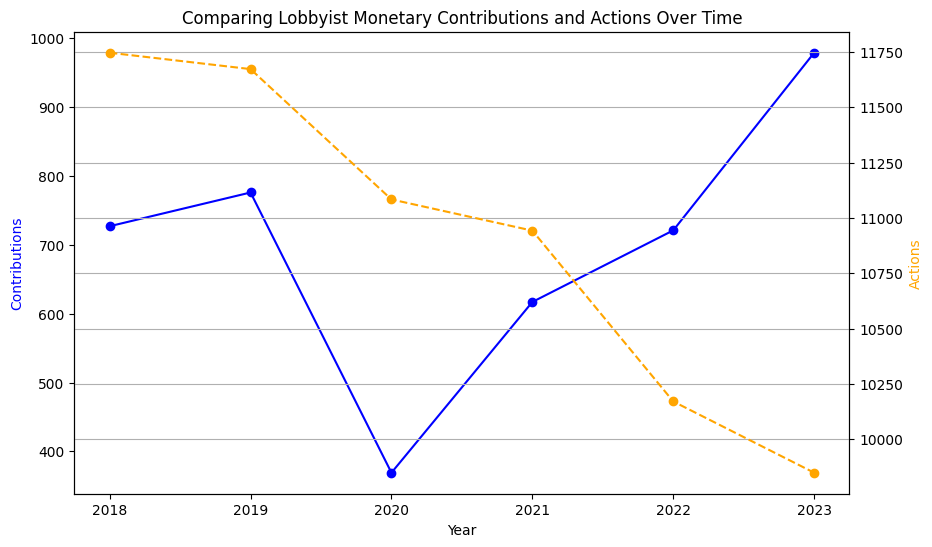

In [16]:
# plotting contributions and actions over time
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(amount_by_year.index, amount_by_year.values, marker='o', linestyle='-', color='blue', label='Contributions')
ax1.set_xlabel('Year')
ax1.set_ylabel('Contributions', color='blue')

ax2 = ax1.twinx()
ax2.plot(actions_by_year.index, actions_by_year.values, marker='o', linestyle='--', color='orange', label='Number of Actions')
ax2.set_ylabel('Actions', color='orange')

plt.title('Comparing Lobbyist Monetary Contributions and Actions Over Time')
plt.grid(True)
plt.show()

Charting the number of contributions and actions over time clearly shows the differences in lobbyist reporting. The correlation is moderately negative where the number of actions do not necessarily follow the number of contributions. The purposes of the different lobbyist record contributes to this graph.

Contributions support recipients monetarily, so during times of economic downturn like in 2020 there is a noticeable drop. The dataset Lobbyist Activity reports more than just financial support, so even with less economic activity in 2020, the number of actions  remained similar to the years previously.

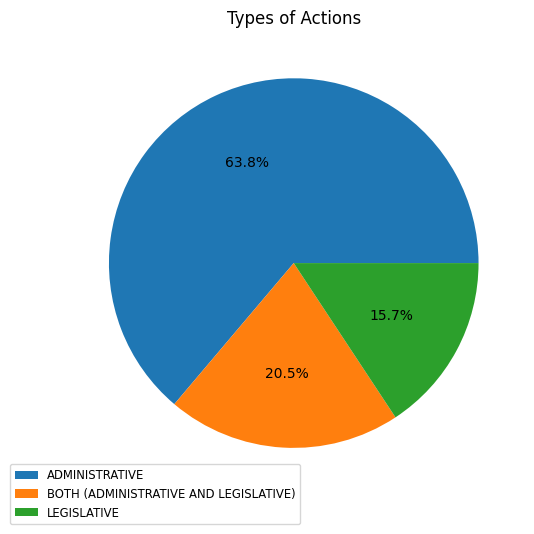

In [17]:
# Plot types of actions
action_counts = wdf_act['action'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(action_counts, labels=None, autopct='%1.1f%%')
plt.title('Types of Actions')
plt.legend(labels=action_counts.index, loc='center', bbox_to_anchor=(0.2, 0), fontsize='small')
plt.show()

The majority of reporting in Lobbyist activity seeks administrative actions. From dealing with zoning issues to development and operations support, the trends in actions do not connect to elections/campaigning as contributions do. There is not a large shift from year to year for the number of types of actions because most of these actions consist of multi-year city projects which lobbyists have consistently contributed to.

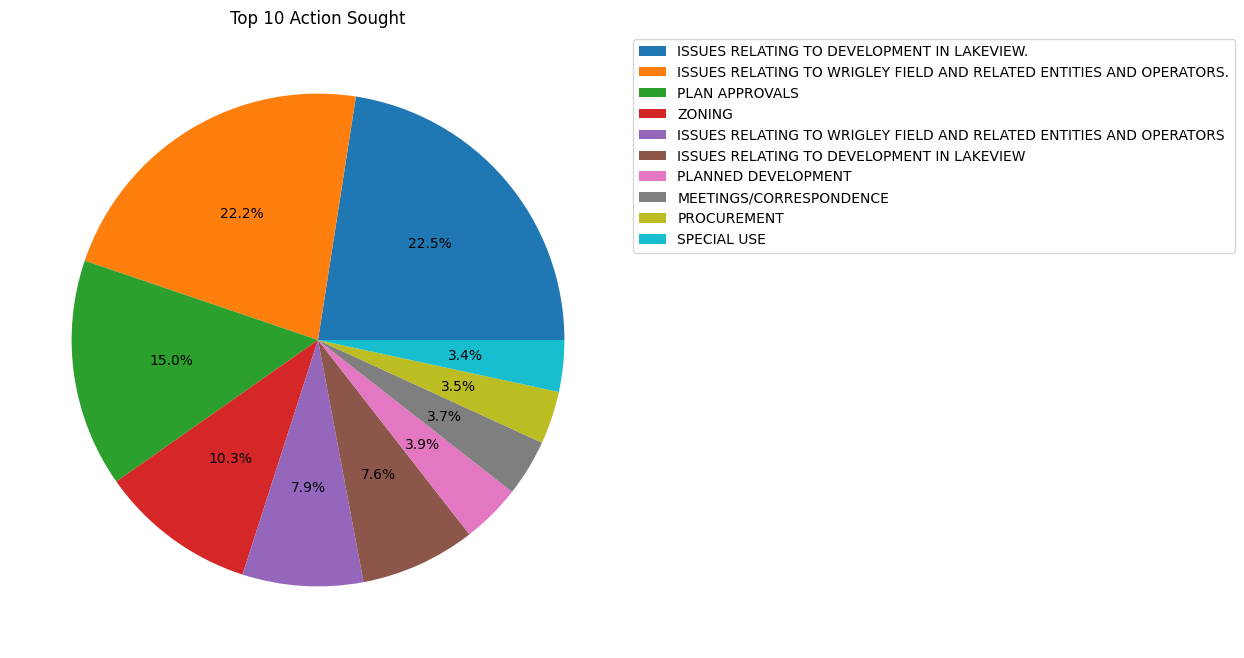

In [18]:
action_counts = w_activity_df['action_sought'].value_counts()
top_10_actions = action_counts.head(10)

# Plot
plt.figure(figsize=(8, 8))
plt.pie(top_10_actions, autopct='%1.1f%%')
plt.title('Top 10 Action Sought')
plt.legend(top_10_actions.index, loc="best", bbox_to_anchor=(1, 1))
plt.show()


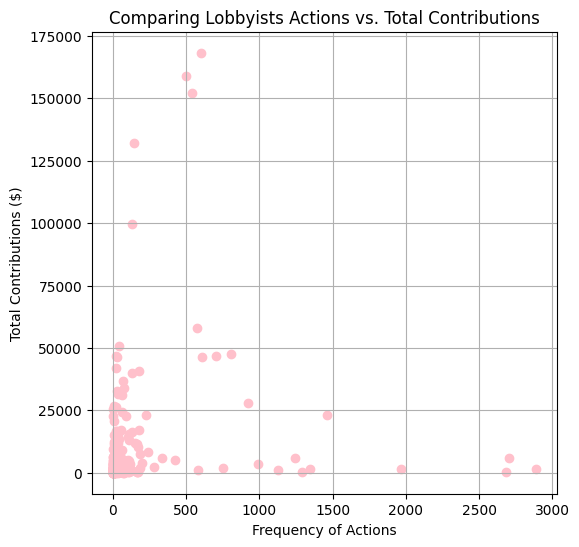

In [19]:
lobbyist_contributions = wdf_contributions.groupby('lobbyist_id')['amount'].sum()
lobbyist_actions = wdf_act['lobbyist_id'].value_counts()

# ensure scatterplot works by limiting to lobbyists in both datasets
valid_lobbyists = lobbyist_actions.index.intersection(lobbyist_contributions.index)
lobbyist_contributions = lobbyist_contributions[valid_lobbyists]
lobbyist_actions = lobbyist_actions[valid_lobbyists]

plt.figure(figsize=(6, 6))
plt.scatter(lobbyist_actions, lobbyist_contributions, color='pink')

plt.xlabel('Frequency of Actions')
plt.ylabel('Total Contributions ($)')
plt.title('Comparing Lobbyists Actions vs. Total Contributions')

plt.grid(True)
plt.show()

The scatterplot visualizes the relationship between Lobbyist Actions and Total Contributions. I wanted to compare these values to check activities in comparison to each other.

While adminstrative make up the majority action type, the amounts vary similarily to the other action types (legislative and both). As shown with the scatterplot the majority of contributions are low. Similar to other boxplot representation of the datasets, the high contribution values represent outliers.



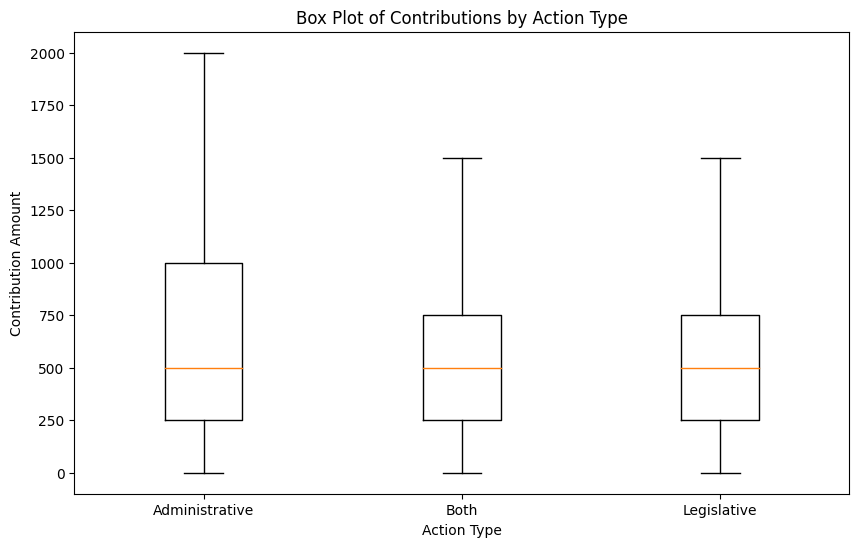

In [20]:
merged_df = pd.merge(w_activity_df, trimmed_working_df, on='lobbyist_id')

administrative_contributions = merged_df[merged_df['action'] == 'ADMINISTRATIVE']['amount']
both_contributions = merged_df[merged_df['action'] == 'BOTH (ADMINISTRATIVE AND LEGISLATIVE)']['amount']
legislative_contributions = merged_df[merged_df['action'] == 'LEGISLATIVE']['amount']

# Plot box plots for each action
plt.figure(figsize=(10, 6))
plt.boxplot([administrative_contributions, both_contributions, legislative_contributions], showfliers=False)
plt.xticks([1, 2, 3], ['Administrative', 'Both', 'Legislative'])
plt.title('Box Plot of Contributions by Action Type')
plt.xlabel('Action Type')
plt.ylabel('Contribution Amount')
plt.show()

In [21]:
# total amount for each action
administrative_total = round(administrative_contributions.sum(), 2)
both_total = round(both_contributions.sum(), 2)
legislative_total = round(legislative_contributions.sum(), 2)

print("Total Amount for Administrative Actions:", administrative_total)
print("Total Amount for Both Actions:", both_total)
print("Total Amount for Legislative Actions:", legislative_total)

Total Amount for Administrative Actions: 607140674.62
Total Amount for Both Actions: 429191992.53
Total Amount for Legislative Actions: 389900560.14


These boxplots remove outliers with showfliers=True, but if this was removed the boxplot would be dispersed even more with the top values. The total contribution amounts are fairly proportional to their type. Administrative actions have a higher total contribution amount because they make up the larger portion of actions while alos having a larger spread of data with the maximum at 2000 by comparison.

### 2. Comparing with Combinations

The Lobbyist Combinations Dataset lists the unique relationships between Lobbyist, Employer, and their clients. This dataset is useful to show the relationships between lobbyists and other individuals and organizations. Through comparison with the Lobbyist Contributions dataset, we can view the direct and indirect actions of lobbyists.

In [22]:
top_10_combo = wdf_combo['lobbyist_id'].value_counts().nlargest(10)
top_10_lobbyist = wdf_lobbyist['lobbyist_id'].value_counts().nlargest(10)
top_10_act = wdf_act['lobbyist_id'].value_counts().nlargest(10)
'''
# View a list of each of top ten
print("Lobbyist Activity\n",top_10_act)
print("Lobbyists Contributions\n",top_10_lobbyist)
print("Combo\n",top_10_combo)
'''

'\n# View a list of each of top ten\nprint("Lobbyist Activity\n",top_10_act)\nprint("Lobbyists Contributions\n",top_10_lobbyist)\nprint("Combo\n",top_10_combo)\n'

<ipython-input-23-c3029aec9abe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_combo.index, y=top_10_combo.values, palette='viridis')


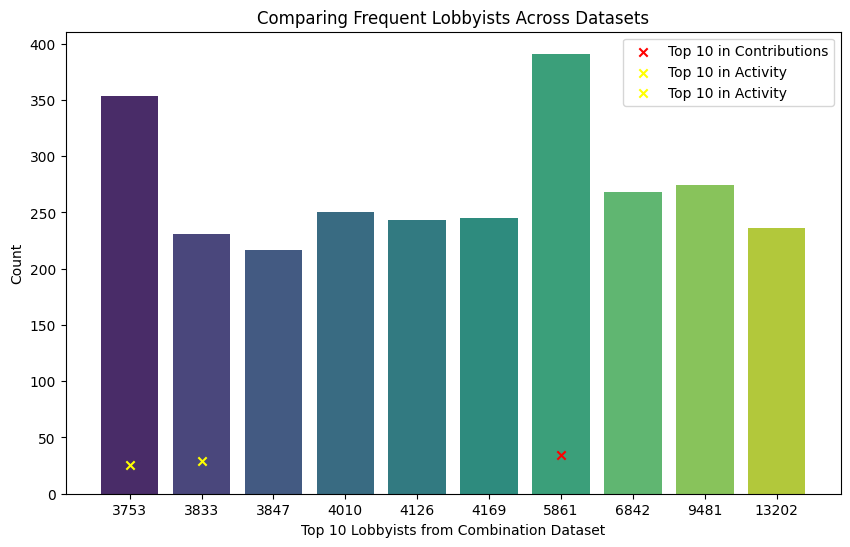

In [23]:
# Plot the top 10 lobbyists from wdf_combo
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_combo.index, y=top_10_combo.values, palette='viridis')

# Use a scatterplot to mark similar lobbyists in contributions and activity datasets
for lobbyist_id, count in top_10_lobbyist.items():
    # mark if in both datasets
    if lobbyist_id in top_10_combo.index:
        x_val = list(top_10_combo.index).index(lobbyist_id)
        y_val = count * 0.3
        ax.scatter(x_val, y_val, color='red', marker='x', label='Top 10 in Contributions')

for lobbyist_id, count in top_10_act.items():
     # mark if in both datasets
    if lobbyist_id in top_10_combo.index:
        x_val = list(top_10_combo.index).index(lobbyist_id)
        y_val = count * 0.02  # move mark down? (that's the only way I found move it)
        ax.scatter(x_val, y_val, color='yellow', marker='x', label='Top 10 in Activity')

ax.set_title("Comparing Frequent Lobbyists Across Datasets")
ax.set_xlabel('Top 10 Lobbyists from Combination Dataset')
ax.set_ylabel('Count')
ax.legend(loc='upper right')
plt.show()

The bar graph above shows the top 10 most frequent lobbyists from the Lobbyist - Contributions dataset. The lobbyists shown have the most interactions with different clients and employers. The scatter plot points show the intersection between the top 10 lobbyists in Combinations to the other datasets.

Observations:
* Lobbyist 5861 is the only top 10 in contributions as well. Looking through this dataset the majority of lobbyists who work with clients do not have substantial political contributions. Most clients look for lobbyists to lobby various actions to city departments and officials who have already been elected, so the contributions do not reflect most of the lobbyist activity.
* Lobbyist 3753 and 3833 are included in the top 10 in Lobbyist Activity. This relationship makes sense since lobbyists who have multiple clients/employers over the years would represent more individuals and their interests.




In [24]:
# count of unique lobbyists in each of the data sets
print("Unique Lobbyists in Combination:", wdf_combo['lobbyist_id'].nunique())
print("Unique Lobbyists in Activity:", wdf_act['lobbyist_id'].nunique())
print("Unique Lobbyists in Contributions:", wdf_contributions['lobbyist_id'].nunique())

Unique Lobbyists in Combination: 1930
Unique Lobbyists in Activity: 1169
Unique Lobbyists in Contributions: 359


The number of unique lobbyists in the Combinations and Activity dataset is significantly larger than those in Contributions. This implies most lobbyists report some form of activity but it is not a political contribution.

# M4: Summary


Through working with multiple datasets the need to group values and compare similar points in data was apparent. Since the Activity and Combo datasets were significantly larger than Lobbyist Contributions, I chose to condense the datasets to a 5-year timeframe. This allowed for a shorter runtime and more consistent data across each dataset (accounted for inconsistencies with early reporting).


Unlike Lobbyist Contributions which followed election results and showed support during campaigning periods, Lobbyist activity was reported more consistently throughout the years on a wide variety of topics.


While there was support for certain individuals (like with recipients in contributions) the majority of actions sought pertained to zoning or development issues. These actions often reported multiple lobbyists from an employer or client towards the issues. This is unlike lobbyist contributions where lobbyists tended to contribute to a wide variety of recipients.


Overall, the use of multiple lobbyist datasets helped show the many parts of government lobbied including political campaigns, budgets/spending, and city planning. They showed the effect of outliers and how very few lobbyists with significant reports (less than 10% overall) impact the datasets.

# M3: Visualizations

To understand the trends and takeaways from this dataset, models are used to represent key points.

From the city of Chicago, the [Election Results](https://chicagoelections.gov/elections/results) are used in analysis as the results of the elections contribute to patterns viewed in Lobbyist contributions. In the Chicago Data Portal there is no dataset representing the Election results (most likely because it would be such a small record), so the summary reports from the link are used.

## 1. Contributions


Based on the visualization above, the periods leading up to election years have the most lobbyist contributions. Particularly, the 2015, 2019, & 2023 elections show high points in the graph as these years were municipal elections where a runoff vote was required. Municipal runoffs occur when a candidate does not meet the minimum threshold of votes to win (usually the majority).


Years with more total contributions tend to have more recipients. This seems to indicate these years have more contributions because of how competitive the year is –not necessarily any one stand-out candidate getting the majority of the contributions. For example, in 2019 there was a record number of mayoral candidates with 14 and the most lobbyist contributions to-date.


The start of the pandemic in 2020 is apparent with a sharp drop in overall contributions for the year. For 2020 the number is well below average with a 52% decrease from the year prior.


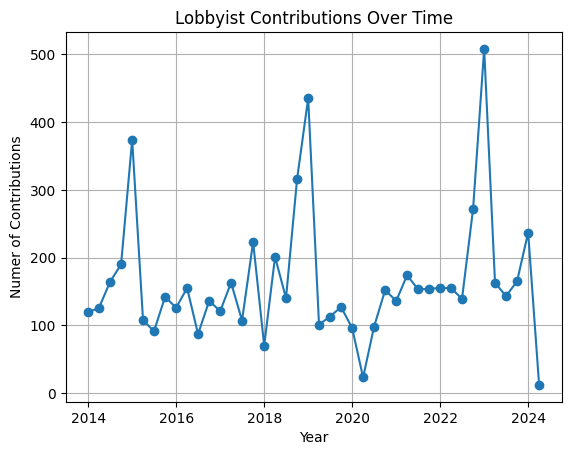

In [25]:
# Contribution_Date by Period_start (quarterly)
ps = trimmed_working_df['period_start']
ps = pd.to_datetime(ps.apply(parse_date))
contributions_by_period = trimmed_working_df.groupby(ps).size()

# Plot
plt.plot(contributions_by_period.index, contributions_by_period.values, marker='o', linestyle='-')

plt.title('Lobbyist Contributions Over Time')
plt.xlabel('Year')
plt.ylabel('Numer of Contributions')

plt.grid(True)
plt.show()

In [26]:
# Another option to visualize the year
cd = trimmed_working_df['period_start']
cd = pd.to_datetime(cd.apply(parse_date))
year = cd.dt.year

# Table format helpful to find areas to examine
print("Year\tTotal Contributions\tTotal Recipients")
for y in year.unique():
  df_year = trimmed_working_df.loc[year == y]
  year_total_contributions = len(df_year)
  year_total_recipients = df_year['recipient'].nunique()
  print("%d\t\t%d\t\t\t%d" % (y, year_total_contributions, year_total_recipients))

Year	Total Contributions	Total Recipients
2024		249			137
2023		979			374
2022		721			327
2021		617			277
2020		369			190
2019		776			353
2018		727			388
2017		614			269
2016		504			271
2015		715			411
2014		599			323


Looking at the overall contributions for the year, the highs and lows are less apparent. Excluding 2020 which had the lowest contributions and recipients, the contributions do not greatly vary year-to-year. With 100-200 more contributions depending on the type of election year. US general election years appear to show less lobbyist contributions to city offices. 🦄

##2. Amount

When comparing the sum of the contributions to the number of contributions, the line graphs follow each other very closely. This graph was mostly to see how similar these two values are, and as shown there is a very strong positive correlation between the sum and number of contributions.

If the sum decreased while the number of contributions then this would indicate More people contributed at smaller amounts than usual. Mid 2019 is an example of this relationship –however few they are.

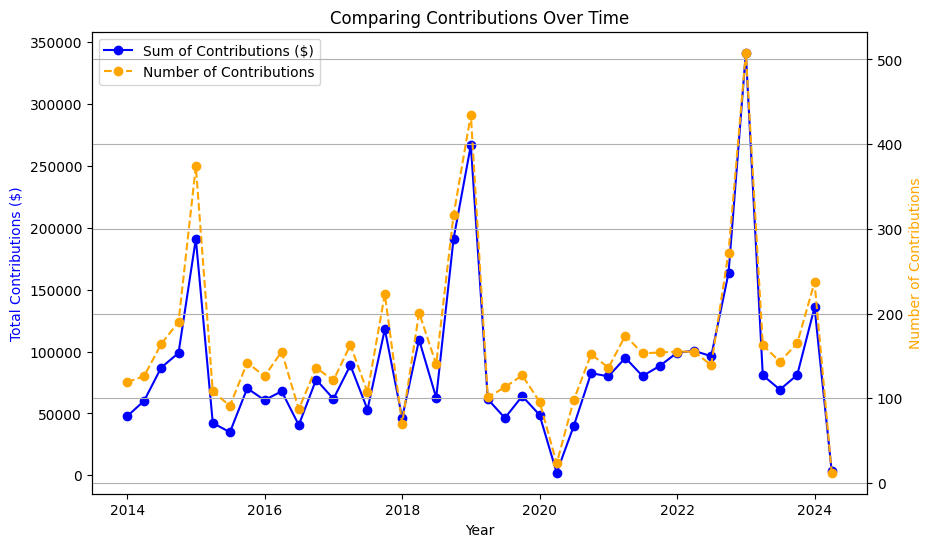

In [27]:
# Get data to plot
count_per_period = trimmed_working_df.groupby(ps).size()
amount_by_period = trimmed_working_df.groupby(ps)['amount'].sum()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Sum & Contributions
ax1.plot(amount_by_period.index, amount_by_period.values, marker='o', linestyle='-', color='blue', label='Sum of Contributions ($)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Contributions ($)', color=  'blue')

ax2 = ax1.twinx()
ax2.plot(count_per_period.index, count_per_period.values, marker='o', linestyle='--', color='orange', label='Number of Contributions')
ax2.set_ylabel('Number of Contributions', color= 'orange')

# Add legend by combining the legends from the subplots
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)
plt.title('Comparing Contributions Over Time')
plt.grid(True)
plt.show()

#print('Correlation:', count_per_period.corr(amount_by_period))

## 3. Recipients


The top ten recipients show the total contributions accumulated since the start of the dataset (10 years ago). The amount of contributions can indicate the level of support or backing a recipient receives from the community. With Chicago city official positions 4-year terms, the top ten recipients are mostly incumbents having won multiple elections


The recipient with the most contributions is "Hopkins for Chicago" with $91,675. Hopkins appears within the top 5 for recipients by amount, frequency, and duration within the dataset. Hopkins has been in office since 2015, so it makes sense for their presence in the data set.


<ipython-input-28-2a50e2054f76>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ten_recipients.index, y=top_ten_recipients.values, palette="viridis", ax=ax)
<ipython-input-28-2a50e2054f76>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['HOPKINS','REILLY',"O'SHEA",'TUNNEY','NUGENT','VALENCIA','MOORE','WAGUESPACK','ERVIN','BURKE'])


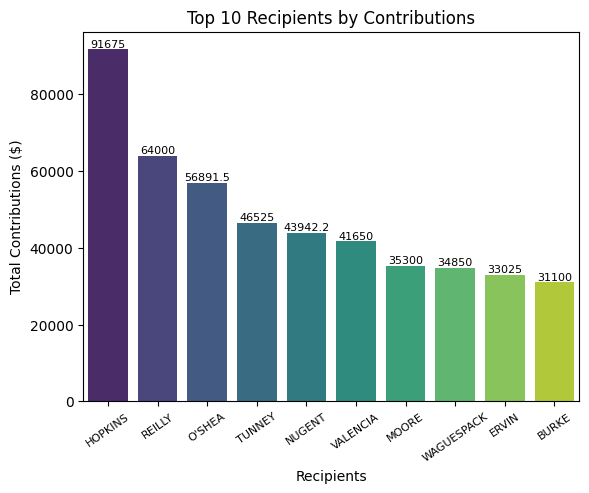

In [28]:
# Graphing top 10 recipients by amount
recipient_by_amount = trimmed_working_df['amount'].groupby(trimmed_working_df['recipient']).sum()
top_ten_recipients = recipient_by_amount.nlargest(10)

bar, ax = plt.subplots()

sns.barplot(x=top_ten_recipients.index, y=top_ten_recipients.values, palette="viridis", ax=ax)

ax.set_ylabel('Total Contributions ($)')
ax.set_xlabel('Recipients')
# Setting tick labels manually to condense the names
ax.set_xticklabels(['HOPKINS','REILLY',"O'SHEA",'TUNNEY','NUGENT','VALENCIA','MOORE','WAGUESPACK','ERVIN','BURKE'])
plt.xticks(rotation=35,fontsize=8)
for i in ax.containers:
    ax.bar_label(i,fontsize=8)
ax.set_title('Top 10 Recipients by Contributions')
plt.show()

The value below is the average contribution amount received by each recipient in the dataset. Of the 6000+ rows, there are over 1500 unique recipients from which the average contribution to a recipient is ~2000. The top ten deviates represent a very small group of recipients with contributions in the tens of thousands.

In [29]:
print("Total contributions of: %.2f$" % (trimmed_working_df['amount'].sum()))
print("Average contributions of a Recipient: %.2f$" % (recipient_by_amount.mean()))
print("Median contributions of a Recipient: %.2f$" % (recipient_by_amount.median()))

Total contributions of: 3738319.78$
Average contributions of a Recipient: 2003.39$
Median contributions of a Recipient: 500.00$


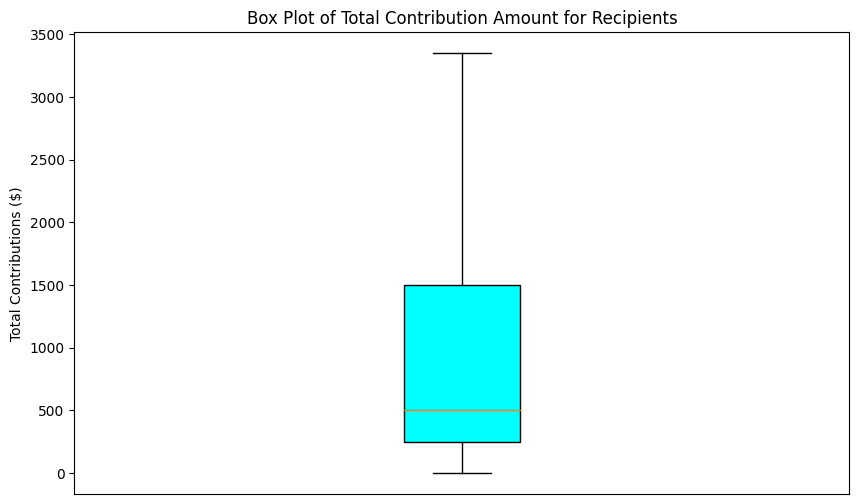

In [30]:
plt.figure(figsize=(10, 6))
# Removing showfliers = False shows the outliers
plt.boxplot(recipient_by_amount, meanline=True, showfliers=False, patch_artist=True, boxprops=dict(facecolor='cyan'))

plt.xticks([]) # gets rid of the '1' tick representing the boxplot
plt.ylabel('Total Contributions ($)')
plt.title('Box Plot of Total Contribution Amount for Recipients')
plt.show()

The boxplot helps quickly show the variability of values in a dataset. Currently, the graph is not representing outliers with ```showfliers=False```

If you remove this line then it will graph the top ten recipients which are far from the rest of the boxplot. With the IQR "maximum" around $3,400 all of the top 10 are considered extreme variations. Burke, the lowest of the top 10, with \$30,600 is still 9x the maximum.

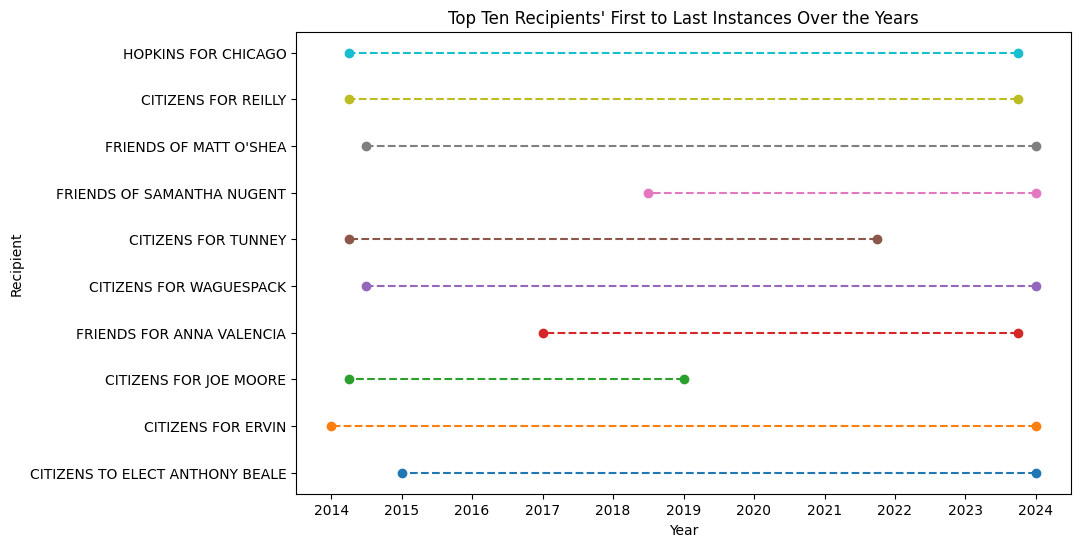

In [31]:
# Find top 10 in the working_df
rec_10 = recipient_by_amount.nlargest(10).index
rec_10_df = trimmed_working_df[trimmed_working_df['recipient'].isin(rec_10)]

# Get the first instance of each recipient in the top ten
first_instances_top_ten = rec_10_df.groupby('recipient').first()
fitt = first_instances_top_ten['period_start']
fitt = pd.to_datetime(fitt.apply(parse_date))

# Get the last
last_instances_top_ten = rec_10_df.groupby('recipient').last()
litt = last_instances_top_ten['period_start']
litt = pd.to_datetime(litt.apply(parse_date))

plt.figure(figsize=(10, 6))
# plot each time line for recipient
for recipient in reversed(rec_10):
    recipient_df = rec_10_df[rec_10_df['recipient'] == recipient]
    plt.plot([fitt[recipient], litt[recipient]], [first_instances_top_ten.loc[recipient].name, last_instances_top_ten.loc[recipient].name], marker='o', linestyle='--', label=recipient)

plt.xlabel('Year')
plt.ylabel('Recipient')
plt.title('Top Ten Recipients\' First to Last Instances Over the Years')
plt.show()


The duration of the recipient's donations helps provide reasons for their difference from average contributions. The longest running recipients, like Hopkins and Reilly, also lead in contribution amount. Winning their elections / holding office also allows them a long duration. If they are in office then (oftentimes) the following elections they will also campaign and receive support.


With the average recipient receiving funds for only about a year, the advantage of being an incumbent/well known is significant. Those with larger total contributions tend to have them spread over a length of time instead of from large contributions.

In [32]:
# Group by lobbyist duration
lob_duration = trimmed_working_df.groupby('lobbyist_id')['period_start'].agg(['min', 'max'])
lob_duration['duration'] = lob_duration['max'] - lob_duration['min']

# Group by recipient duration
recipient_duration = trimmed_working_df.groupby('recipient')['period_start'].agg(['min', 'max'])
recipient_duration['duration'] = recipient_duration['max'] - recipient_duration['min']

# Calculate the average
average_lob_duration = lob_duration['duration'].mean()
average_duration = recipient_duration['duration'].mean()

print("Average duration of a lobbyist in the dataset:", average_lob_duration)
print("Average duration of a recipient in the dataset:", average_duration)

Average duration of a lobbyist in the dataset: 857 days 14:13:05.746102448
Average duration of a recipient in the dataset: 422 days 20:52:28.553054664


## 4. Lobbyists

Lobbyists represent the other side of contributions. The lobbyist pool is about 3x smaller than the recipients. They also tend to have a larger duration in the dataset. Essentially, they are fewer in number but participate for longer.

In [33]:
# Grouping of basic data analysis
lob_total = lobbyist_df['lobbyist_id'].nunique()

print('Number of reported lobbyists:', lob_total)
print("Average duration:", average_lob_duration)

Number of reported lobbyists: 449
Average duration: 857 days 14:13:05.746102448


<ipython-input-34-97735933f1b6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lob_10.index, y=lob_10.values, palette="viridis", ax=ax)


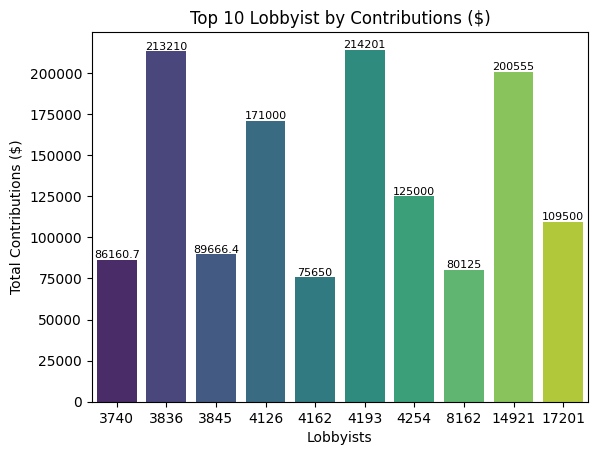

In [34]:
# grouping lobbyists by contributions
lobbyist_by_amount = lobbyist_df.groupby('lobbyist_id')['amount'].sum()
lob_10 = lobbyist_by_amount.nlargest(10)
lob_10 = lob_10.sort_values(ascending=False)

bar, ax = plt.subplots()
sns.barplot(x=lob_10.index, y=lob_10.values, palette="viridis", ax=ax)

ax.set_ylabel('Total Contributions ($)')
ax.set_xlabel('Lobbyists')
# adding values to bar
for i in ax.containers:
    ax.bar_label(i,fontsize=8)
ax.set_title('Top 10 Lobbyist by Contributions ($)')
plt.show()

Similar to the Top 10 recipients, the lobbyist with the largest amount of contributions has been active in the dataset since the beginning.


At first glance, the amount is spread over time and recipients, but the aggregate total of the top 10 shows their significance. However the lobbyists have made significant contributions in comparison to the overall total with 35% of the total contributions made from the 10 lobbyists.

In [35]:
red_10 = recipient_by_amount.nlargest(10).sum()
print("Top 10s percentage of total contributions: %.2f" % (red_10.sum() / trimmed_working_df['amount'].sum()*100))
print("Top 10s percentage of total contributions: %.2f" % (lob_10.sum() / trimmed_working_df['amount'].sum()*100))

Top 10s percentage of total contributions: 12.81
Top 10s percentage of total contributions: 36.52


# M3: Summary

The Lobbyist – Contributions dataset is valuable to examine when looking at transparency and ethical behavior in government. Required lobbyist reporting creates a standard which can be used to ensure compliance and accountability.

<br>The majority of recipients receive around \$2000 in contributions with the median contribution \$500. Both the top recipients and lobbyists represent outlier groups where the average person does not give/receive such large amounts. We can attribute these large amounts to lobbyists and recipients who have been reported in the dataset over a large length of time.

<br>The majority of the top 10 lobbyists have reports from the start of this dataset in 2015, and they have consistently contributed to various recipients resulting in their high overall total. While there is a large sample of recipients, there is a lack of variability in the lobbyist group with the top 100 lobbyists making up 90% of the total contributions. Primarily, these numbers make sense for registration of a lobbyist, the reporting process, and the contributions are not everyday tasks. However, as a place of political influence and participation it would be ideal to have more participants (not necessarily in amount but the total.)

<br>This dataset is important to understanding political financing.
Policymakers can reference this data to make decisions that align with public opinion. Lobbying is a critical form of political participation. They can indicate the motivations / activity of the community, the effect of elections, and more.

# M3: Project Proposal
---
**Milestone 3: Data Mining in Lobbyist Data - Contributions**

*By Marissa Bui*


**Introduction:**
Within the modern political landscape, there is a significant impact of lobbying during political campaigns. Lobbyist data provides valuable information which can help show the influence of money in politics. Chicago's lobbyist law is one of the broadest in the U.S. with registered lobbyists required to report every political contribution. Transparency of contributions is integral to maintaining integrity in government.

During this project I will work with the Chicago Lobbyist dataset to discover trends, patterns, and predictions within the data. Through this analysis I hope to gain a comprehensive understanding of lobbyist contributions and their influence on politics. I will also improve my skills on analyzing and manipulating larger sets of data.

<br>**Dataset Description:**
The dataset used for this project is the [Lobbyist Data – Contributions](https://data.cityofchicago.org/Ethics/Lobbyist-Data-Contributions/p9p7-vfqc/about_data) for Chicago. Under the category of ethics in the Chicago Data Portal, this dataset includes lobbyist identification such as name and ID, recipients, amount, and contribution date/period.

<br>**Significance:** This dataset can be used to examine the relationship of interest groups, political candidates, and private individuals. By examining this data, I can gain a good understanding of how contributions affect policy and political campaigns.
Purpose of Data Analysis (importance):

By examining this dataset I seek to:
- Analyze patterns in political contributions by date and amount
- Explore the relationship between lobbyists and political campaigns
- Identify key contributors
- Understand the influence of monetary contributions

The aim of the data analysis on political contributions is to discover trends between lobbying and political campaigns. These patterns may indicate the long-term influence of the private sector on government, effect on elections and policies, and the support for various political groups within the city.


<br>**Deliverables:**
By the end of February, the deliverables for this project will include:

1. Data Analysis Report: This data analysis report will be a detailed examination of the Lobbyist Contributions dataset. The report will develop conclusions based on data mining techniques like descriptive statistics, variable relationships, and visualizations.
2. Data Visualization: A visual representation of key findings and trends discovered during analysis will be provided. The purpose of this model is to ease data exploration and explain conclusions concisely through a visual.
3. Summary: An executive summary will be prepared on the analysis which will be a brief explanation on the trends and areas of interest within the dataset. This will include concluding thought on political financing.

<br>**Resources & Requirements:**
For this project Python-based tools including pandas, matplotlib.pyplot, and perhaps seaborn will be used. Access to the dataset will be established via the Socrata API, supported by the Chicago Data Portal. Documentation for these tools is available at their respective websites. Additional assistance is available by reaching out to the course instructor.

<br>**Timeline**
A work schedule based on progressing through deliverables will be established to create checkpoints to monitor progress and address issues when needed. The approach to deliverables will be in sequential order, first the work will be examining the dataset and the tools required, then to building the models to later drafting a report based on their conclusions. Throughout the process I plan to add to the report and document questions for the instructor. While waiting for a response, I will allocate time for the reading assignments and reviewing the material. As an initial schedule draft, the first week will work on identifying relationships and familiarizing with the tools for the project. The second week will focus on visualizations and gathering information for the report.

<br>**Proposal Conclusion:**
This proposal outlines the comprehensive approach to data mining using the Lobbyist Contributions dataset as the example. Ultimately, this project seeks to examine the contributions, transparency, and influence in political financing. Through the patterns and trends in lobbyist contributions, we can potentially uncover motivations for contributions and highlight potential areas of concern such as excessive influence or potential loopholes.

# M5: Lobbyist Datasets Summary
Lobbyist data provides valuable information which can show the significance of monetary contributions within government. From political and legislative support to urban planning, it is integral to examine lobbyist actions for public transparency. The Chicago Data Portal provides a variety of lobbyist datasets which seek to structure information reported to the Chicago Board of Ethics by registered lobbyists. This project examined the following datasets to gain a comprehensive understanding of lobbying in Chicago.


* [Lobbyist Data – Contributions](https://data.cityofchicago.org/Ethics/Lobbyist-Data-Contributions/p9p7-vfqc/about_data)
* [Lobbyist, Employer, Client Combinations](https://data.cityofchicago.org/Ethics/Lobbyist-Data-Lobbyist-Employer-Client-Combination/2eqz-3nvz/about_data)
*[Lobbyist - Activity](https://data.cityofchicago.org/Ethics/Lobbyist-Data-Lobbying-Activity/)


The Lobbyist Data - Contributions dataset shows the political contributions of lobbyists. Similar to the other two datasets, the majority of the reported contributions are low with the median amount being $500. With total political contributions at 3.7 mil, many recipients receive smaller one-time amounts instead of large lump sums. Those with significant contributions in the dataset represent the top ten recipients and lobbyists. Over 1 million dollars are reported by the same ten lobbyists, the majority having spent at least a decade as a registered lobbyist (the dataset does not record prior to 2014). The trends within lobbyist contributions follow closely with election campaigns and the economy. In 2020 where the Coronavirus affected people greatly, there is a large dip in political contributions. Other lobbyist datasets do not necessarily show this impact since they are not solely financially driven.


The Lobbyist, Employer, Client - Combinations dataset joins the different identifiers to show unique relationships between them. This dataset can show the level of engagement from lobbyists as they interact with clients and employers. There is not much overlap between Combinations and the other two datasets, with most lobbyists and client pairings involving either activity or contributions. For example, on behalf of a client, a lobbyist might report in the activity dataset seeking plan approvals. Another lobbyist might contribute to a political campaign. More often, lobbyists with clients report more Lobbyist Activity than political contributions as they act on behalf of a client.


The Lobbyist Activity represents the last dataset used in this project. Filled with information such as action type and description, the activity allows for more detailed examination into lobbying. Areas with significant lobbying include development in Wrigley field area and Lakeview area. Considering these areas have high public traffic and commerce, these areas involve more competitive lobbying from clients and employers. Zoning is also a major decision which was reported under many different names “Zoning”, “Zoning Areas”, “Sections for Zoning”, etc. The difference in names makes the visualization of the total zoning-related issues difficult, but at least 10% of all actions sought pertain to zoning. These areas which deal with land and resource allocation are important to lobbyists as they deal with prospective business and investments.




Those who lobby or hire lobbyists seek some sort of gain through their support. Whether it is a candidate in office they agree with or an beneficial legislative action, the reports in the lobbyist dataset indicate motivation. With the majority of funds and contributions deriving from a select few (mostly 25 people from each set), their influence is clear. Even in activity areas like Lakeview development which show competitive lobbying, the total participants are restricted to less than 50. Lobbyists, in comparison to the clients, employers, and political recipients they are connected to, are few and influential. The lobbyist datasets show the impact of these lobbyists as they drive the majority of funds and contributions.

# M5: Ungrading Reflection

I believe this project is a good example of my work throughout this term. Using a variety of graphs and representations of the data, I looked to gain familiarity in different techniques. The code is well structured and documented to include analysis throughout. More so, I felt choosing what to look into/what to keep during the final model was an important part of the learning process. Once I was more familiar with graphs/python it was a matter of how to use it. I felt the API models in the Chicago Data Portal website were helpful in choosing my representations of the data, and I worked within them a lot. I chose to examine the top ten items of the dataset since I noticed a pattern where their contributions were significantly higher than others. Throughout this project, the milestone's have been a great opporuntiy to explore and expand my skills in data mining. Based on previous feedback and my growth/time spent through out the term I believe my grade should be an A.